<a href="https://colab.research.google.com/github/walnashgit/ERAV2/blob/main/S8/GroupNormalization/S8CIFAR_GN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
# exp = datasets.CIFAR10('./data', train = True, download = True, transform = simple_transforms)

# data = exp.data / 255  # dividing by max pixel value to scale the data between 0-1
# print(' - data.mean():', data.mean(axis=(0,1,2)))
# print(' - data.std():', data.std(axis=(0,1,2)))

# - data.mean(): [0.49139968 0.48215841 0.44653091]
# - data.std(): [0.24703223 0.24348513 0.26158784]

#Prepare basic transforms using mean and std from above.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2471, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2471, 0.2435, 0.2616))
])

train_set = datasets.CIFAR10('./data', train = True, download = True, transform = train_transforms)
test_set = datasets.CIFAR10('./data', train = False, download = True, transform = test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 14138958.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
SEED = 4
# for CUDA
cuda = torch.cuda.is_available()
print("CUDA available: ", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

# Create data loader, default for CPU
dataloader_args = dict(shuffle=True, batch_size=128)

if cuda:
    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)


# Train loader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# Test loader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA available:  True


In [4]:
dropout_value = 0.05

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias=False),  # RF: 3, OP: 32
            nn.GroupNorm(4, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),  # RF: 5, OP: 32
            nn.GroupNorm(4, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # c3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),  # RF: 5, OP: 32
        )
        # P1
        self.pool1 = nn.MaxPool2d(2, 2)  # RF: 6, OP: 16

        # C4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1, bias=False),  # RF: 10, OP: 16
            nn.GroupNorm(4, 16),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # C5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias=False),  # RF: 14, OP: 16
            nn.GroupNorm(8, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # C6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),  # RF: 18, OP: 16
            nn.GroupNorm(8, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # c7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),  # RF: 18, OP: 16
        )
        # P2
        self.pool2 = nn.MaxPool2d(2, 2)  # RF:20, OP: 8

        # C8
        self.convblock8 = nn.Sequential(
            nn.Conv2d(10, 32, 3, padding=1, bias=False),  # RF: 28, OP: 8
            nn.GroupNorm(4, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # C9
        self.convblock9 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),  # RF: 36, OP: 8
            nn.GroupNorm(4, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # C10
        self.convblock10 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, bias=False),  # RF:44, OP: 8
            nn.GroupNorm(4, 32),  # grp, ch
            nn.ReLU(),
            nn.Dropout2d(dropout_value)
        )

        # GAP
        self.gap1 = nn.AdaptiveAvgPool2d(1)  # OP: [X, 32, 1, 1] ; X = Batch size

        # c11
        self.convblock11 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),  # OP: [X, 10, 1, 1]
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.convblock7(x)
        x = self.pool2(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        x = self.gap1(x)

        x = self.convblock11(x)

        x = x.view(-1, 10)  # OP: [128, 10]

        x = F.log_softmax(x, dim=-1)

        return x

In [5]:
# Select device based on available GPU/CPU
device = torch.device("cpu")
if cuda:
    device = torch.device("cuda")

network = Network().to(device)
summary(network, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
         GroupNorm-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
         GroupNorm-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         Dropout2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             320
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
        GroupNorm-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
        Dropout2d-14           [-1, 16,

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
missclassified_images = []


def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # print('- y_pred:', y_pred.shape)

    # Calculate loss
    #loss = F.cross_entropy(y_pred, target) # nn.CrossEntropyLoss(y_pred, target)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            F.cross_entropy(output, target, reduction='sum').item()
            # test_loss += nn.CrossEntropyLoss(output, target, reduction='sum')
            #test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # find miss-classified images in last epoch
            if epoch == EPOCHS - 1:
                misclassified_indices = (pred != target.view_as(pred)).nonzero()[:, 0]
                for idx in misclassified_indices:
                    missclassified_images.append((data[idx].cpu(), target[idx].cpu(), pred[idx].cpu()))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


In [7]:
# Running the model
model =  network.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    #scheduler.step()

EPOCH: 0


Loss=1.8511292934417725 Batch_id=390 Accuracy=22.86: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]



Test set: Average loss: 1.7197, Accuracy: 3548/10000 (35.48%)

EPOCH: 1


Loss=1.5275675058364868 Batch_id=390 Accuracy=36.54: 100%|██████████| 391/391 [00:18<00:00, 20.79it/s]



Test set: Average loss: 1.4895, Accuracy: 4531/10000 (45.31%)

EPOCH: 2


Loss=1.3534619808197021 Batch_id=390 Accuracy=45.00: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]



Test set: Average loss: 1.3069, Accuracy: 5335/10000 (53.35%)

EPOCH: 3


Loss=1.1695557832717896 Batch_id=390 Accuracy=50.14: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 1.2052, Accuracy: 5622/10000 (56.22%)

EPOCH: 4


Loss=1.3719289302825928 Batch_id=390 Accuracy=53.78: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s]



Test set: Average loss: 1.1988, Accuracy: 5732/10000 (57.32%)

EPOCH: 5


Loss=1.1587294340133667 Batch_id=390 Accuracy=56.78: 100%|██████████| 391/391 [00:19<00:00, 19.90it/s]



Test set: Average loss: 1.0619, Accuracy: 6166/10000 (61.66%)

EPOCH: 6


Loss=0.9996695518493652 Batch_id=390 Accuracy=58.84: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.9988, Accuracy: 6405/10000 (64.05%)

EPOCH: 7


Loss=0.9494478106498718 Batch_id=390 Accuracy=60.44: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 1.0016, Accuracy: 6366/10000 (63.66%)

EPOCH: 8


Loss=1.0349955558776855 Batch_id=390 Accuracy=61.95: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]



Test set: Average loss: 0.9352, Accuracy: 6667/10000 (66.67%)

EPOCH: 9


Loss=1.0372092723846436 Batch_id=390 Accuracy=63.33: 100%|██████████| 391/391 [00:18<00:00, 21.19it/s]



Test set: Average loss: 0.9231, Accuracy: 6662/10000 (66.62%)

EPOCH: 10


Loss=1.1253745555877686 Batch_id=390 Accuracy=64.37: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]



Test set: Average loss: 0.8830, Accuracy: 6816/10000 (68.16%)

EPOCH: 11


Loss=1.1568634510040283 Batch_id=390 Accuracy=65.45: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.8705, Accuracy: 6951/10000 (69.51%)

EPOCH: 12


Loss=0.9928275942802429 Batch_id=390 Accuracy=66.46: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]



Test set: Average loss: 0.8561, Accuracy: 6974/10000 (69.74%)

EPOCH: 13


Loss=0.8597954511642456 Batch_id=390 Accuracy=67.74: 100%|██████████| 391/391 [00:18<00:00, 21.21it/s]



Test set: Average loss: 0.8620, Accuracy: 6972/10000 (69.72%)

EPOCH: 14


Loss=0.8368112444877625 Batch_id=390 Accuracy=68.34: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.8101, Accuracy: 7130/10000 (71.30%)

EPOCH: 15


Loss=0.7639325261116028 Batch_id=390 Accuracy=68.94: 100%|██████████| 391/391 [00:18<00:00, 21.07it/s]



Test set: Average loss: 0.7741, Accuracy: 7257/10000 (72.57%)

EPOCH: 16


Loss=0.9306824803352356 Batch_id=390 Accuracy=69.71: 100%|██████████| 391/391 [00:18<00:00, 21.09it/s]



Test set: Average loss: 0.8036, Accuracy: 7153/10000 (71.53%)

EPOCH: 17


Loss=0.9125494956970215 Batch_id=390 Accuracy=69.66: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]



Test set: Average loss: 0.8025, Accuracy: 7147/10000 (71.47%)

EPOCH: 18


Loss=1.0306308269500732 Batch_id=390 Accuracy=70.58: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]



Test set: Average loss: 0.7546, Accuracy: 7359/10000 (73.59%)

EPOCH: 19


Loss=0.9234035611152649 Batch_id=390 Accuracy=71.01: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]



Test set: Average loss: 0.7573, Accuracy: 7308/10000 (73.08%)



Text(0.5, 1.0, 'Test Accuracy')

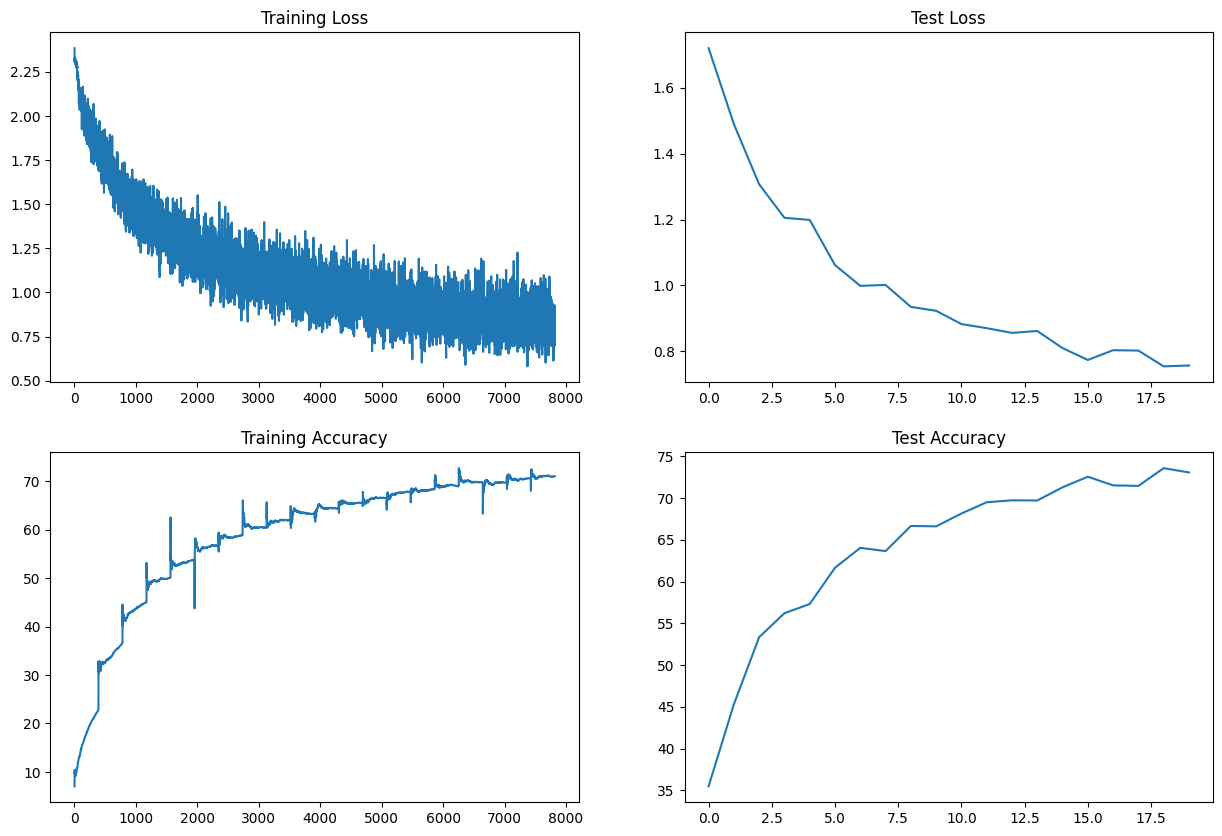

In [8]:
# Plot the training and test loss and accuracy
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

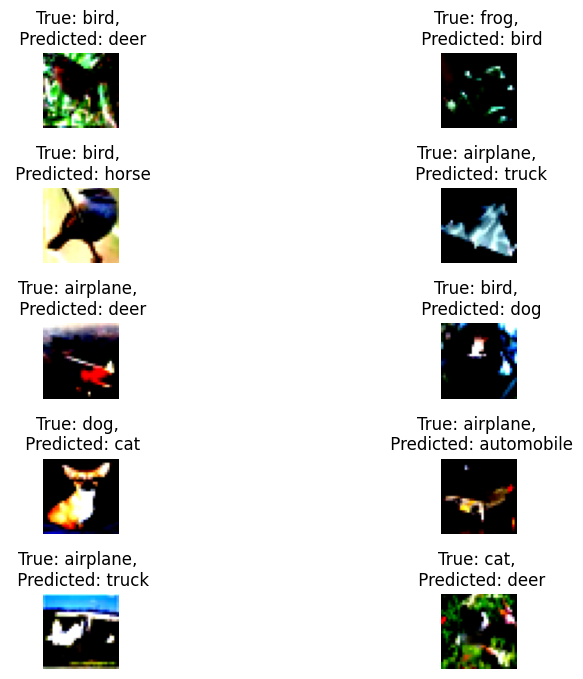

In [9]:
import numpy as np

def plot_misclassified_images(misclassified_images, num_images=10):
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(wspace=0.8, hspace=0.8)
    for i in range(min(num_images, len(misclassified_images))):
        image, true_label, predicted_label = misclassified_images[i]
        ax = fig.add_subplot(5, 2, i + 1)
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(f'True: {train_set.classes[true_label]}, \n Predicted: {train_set.classes[predicted_label]}')
        ax.axis('off')
    #plt.show()

plot_misclassified_images(missclassified_images)